# Download the dataset

In [1]:
from tqdm import tqdm
import urllib

url = "https://storage.googleapis.com/linnarsson-lab-www-blobs/blobs/cortex/expression_mRNA_17-Aug-2014.txt"
r = urllib.urlopen(url)
total_size = int(r.headers['content-length'])/1000; 

def readIter(f, blocksize=1000):
    """Given a file 'f', returns an iterator that returns bytes of
    size 'blocksize' from the file, using read()."""
    while True:
        data = f.read(blocksize)
        if not data: break
        yield data
        
with open('expression.bin', 'wb') as f:
    for data in tqdm(readIter(r), total=total_size, unit='KB', unit_scale=False):
        f.write(data)

121130KB [00:12, 9910.96KB/s]                             


# Import the scVI model

In [2]:
%load_ext autoreload
%autoreload 2
import scVI
import tensorflow as tf
from benchmarking import *

In [3]:
import numpy as np
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

# Loading and filtering data

In [4]:
X = pd.read_csv("expression.bin", sep="\t", low_memory=False).T
clusters = np.array(X[7], dtype=str)[2:]
_, labels = np.unique(clusters, return_inverse=True)
gene_names = np.array(X.iloc[0], dtype=str)[10:]
X = X.loc[:, 10:]
X = X.drop(X.index[0])
expression_data = np.array(X, dtype=np.int)[1:]

# keep the most variable genes according to the Biscuit ICML paper
selected = np.std(expression_data, axis=0).argsort()[-558:][::-1]
expression_data = expression_data[:, selected]
gene_names = gene_names[selected].astype(str)

#train test split for log-likelihood scores
expression_train, expression_test, c_train, c_test = train_test_split(expression_data, labels)

# Getting prior for scaling parameters

In [5]:
log_library_size = np.log(np.sum(expression_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

# Loading scVI on memory

In [6]:
batch_size = 128
learning_rate = 0.001
epsilon = 0.01
latent_dimension = 10

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                        optimize_algo=optimizer, phase=training_phase, \
                        library_size_mean=mean, library_size_var=var,\
                        n_hidden=128, dropout_rate=0.1, n_layers=1, \
                        n_latent=latent_dimension, log_variational=True)

Running scVI on 558 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space


# Creating TensorFlow session

In [7]:
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Training

In [8]:
def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index].astype(np.float32)

In [9]:
def train_model(num_epochs, expression_train, expression_test, step, kl_scale=1):
    iterep = int(expression_train.shape[0]/float(batch_size))-1  
    
    for t in range(iterep * num_epochs):
            
        # arange data in batches
        x_train = next_batch(expression_train, batch_size)
        x_test = next_batch(expression_test, batch_size)

        #prepare data dictionaries
        dic_train = {expression: x_train, training_phase:True, kl_scalar:kl_scale}
        dic_test = {expression: expression_test, training_phase:False, kl_scalar:kl_scale} 
        
        # run an optimization set
        _, l_tr = sess.run([step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:          
            
            print epoch
            l_t = sess.run((model.loss), feed_dict=dic_test)
            
            print 'Train / Test performance:', l_tr, l_t
            
            if np.isnan(l_tr):
                break

In [10]:
# this takes 45 seconds on a Tesla K80
train_model(200, expression_train, expression_test, model.train_step, kl_scale=0)

0
Train / Test performance: 37617.7 31705.9
1
Train / Test performance: 21906.1 3805.14
2
Train / Test performance: 16495.9 5666.47
3
Train / Test performance: 12304.2 7008.06
4
Train / Test performance: 8214.28 5653.42
5
Train / Test performance: 6625.61 3236.49
6
Train / Test performance: 4111.08 2811.63
7
Train / Test performance: 3000.85 3226.63
8
Train / Test performance: 2649.19 4219.41
9
Train / Test performance: 2105.59 2955.46
10
Train / Test performance: 2045.29 3981.95
11
Train / Test performance: 1830.24 3324.35
12
Train / Test performance: 1783.09 2304.52
13
Train / Test performance: 1645.91 2113.57
14
Train / Test performance: 1814.6 1975.24
15
Train / Test performance: 1708.7 2137.88
16
Train / Test performance: 1718.58 1805.82
17
Train / Test performance: 1769.07 1802.74
18
Train / Test performance: 1539.02 1766.72
19
Train / Test performance: 1551.62 1671.58
20
Train / Test performance: 1651.25 1756.96
21
Train / Test performance: 1717.14 1677.41
22
Train / Test perfor

182
Train / Test performance: 1354.92 1369.37
183
Train / Test performance: 1324.7 1355.88
184
Train / Test performance: 1373.52 1378.78
185
Train / Test performance: 1339.78 1366.2
186
Train / Test performance: 1374.16 1391.37
187
Train / Test performance: 1348.89 1601.23
188
Train / Test performance: 1361.57 1338.92
189
Train / Test performance: 1361.47 1336.41
190
Train / Test performance: 1281.88 1339.7
191
Train / Test performance: 1346.72 1341.44
192
Train / Test performance: 1323.77 1335.55
193
Train / Test performance: 1328.9 1325.64
194
Train / Test performance: 1363.28 1332.51
195
Train / Test performance: 1366.06 1341.5
196
Train / Test performance: 1329.73 1342.09
197
Train / Test performance: 1350.03 1454.34
198
Train / Test performance: 1423.74 1326.15
199
Train / Test performance: 1352.04 1329.26


# Clustering

In [11]:
def eval_latent(data, sess, model):
    dic_full = {expression: data, training_phase:False, kl_scalar:1}
    return sess.run(model.z, feed_dict=dic_full)

We can here sample fron the latent space, you can verify that the clustering metrics are robust with respect to different samples from the variational posterior

In [12]:
latent = eval_latent(expression_train, sess, model)
print distances_metrics(latent, c_train)
print best_clusters_score(latent, len(np.unique(c_train)), c_train)

{'nne': 0.93608521970705727, 'silhouette': 0.31632379}
{'ARI': 0.67091244079640644, 'F1': 0.59709220592763401, 'NMI': 0.71729901676152974}


# Visualization

Our latent space is low-dimensional and therefore tSNE friendly !

In [13]:
def show_tSNE(latent, labels):
    tsne = TSNE().fit_transform(latent)
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, \
                                   cmap=plt.get_cmap("tab10", 7), edgecolors='none')
    plt.axis("off")
    plt.title("tSNE for scVI", fontsize=16)

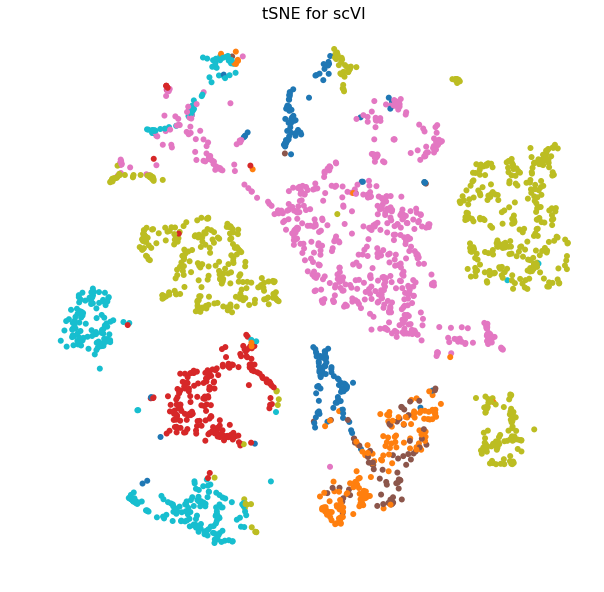

In [14]:
show_tSNE(latent, c_train)

# Imputation

We now turn to the imputation result. For that, we need to recomplete scVI's inference on corrupted data. That means clearing the computation graph of TensorFlow and starting with a new one. We corrupt the data by uniform sampling over the non-zero entries (10%)

In [15]:
X_zero, i, j, ix = dropout(expression_train)

In [16]:
batch_size = 128
learning_rate = 0.001
epsilon = 0.01
latent_dimension = 10

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                        optimize_algo=optimizer, phase=training_phase, \
                        library_size_mean=mean, library_size_var=var,\
                        n_hidden=128, dropout_rate=0.1, n_layers=1, \
                        n_latent=latent_dimension, log_variational=True)
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Running scVI on 558 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space


In [17]:
train_model(300, X_zero, expression_test, model.train_step, kl_scale=1)

0
Train / Test performance: 27543.5 33187.6
1
Train / Test performance: 22296.2 4755.98
2
Train / Test performance: 16854.5 5135.89
3
Train / Test performance: 12814.1 8115.36
4
Train / Test performance: 7347.26 6568.56
5
Train / Test performance: 6228.28 5550.29
6
Train / Test performance: 3928.6 3044.52
7
Train / Test performance: 3141.22 2665.38
8
Train / Test performance: 2997.34 2549.46
9
Train / Test performance: 2391.13 2796.25
10
Train / Test performance: 2019.87 2551.23
11
Train / Test performance: 1705.51 2312.67
12
Train / Test performance: 1803.93 2394.76
13
Train / Test performance: 1709.19 2434.94
14
Train / Test performance: 1552.8 2165.94
15
Train / Test performance: 1561.94 2063.71
16
Train / Test performance: 1552.69 2177.47
17
Train / Test performance: 1674.09 2094.3
18
Train / Test performance: 1509.99 2240.17
19
Train / Test performance: 1604.5 1818.45
20
Train / Test performance: 1511.34 1899.2
21
Train / Test performance: 1514.31 1751.53
22
Train / Test performan

182
Train / Test performance: 1324.29 1559.47
183
Train / Test performance: 1359.56 1425.75
184
Train / Test performance: 1325.94 1390.42
185
Train / Test performance: 1362.58 1398.06
186
Train / Test performance: 1358.17 1387.78
187
Train / Test performance: 1316.08 1391.52
188
Train / Test performance: 1269.6 1395.71
189
Train / Test performance: 1294.39 1390.97
190
Train / Test performance: 1414.98 1520.76
191
Train / Test performance: 1369.64 1480.1
192
Train / Test performance: 1320.4 1388.25
193
Train / Test performance: 1342.58 1404.01
194
Train / Test performance: 1302.87 1383.67
195
Train / Test performance: 1405.56 1421.87
196
Train / Test performance: 1299.28 1439.88
197
Train / Test performance: 1288.62 1395.85
198
Train / Test performance: 1312.82 1464.36
199
Train / Test performance: 1354.13 1391.39
200
Train / Test performance: 1366.98 1394.56
201
Train / Test performance: 1358.77 1396.12
202
Train / Test performance: 1362.58 1390.19
203
Train / Test performance: 1305.16

In [18]:
def eval_imputed_data(model):
    dic_zero = {expression: X_zero, training_phase:False, kl_scalar:1.} 
    rate_ = sess.run(model.px_rate,  feed_dict=dic_zero)
    return imputation_error(rate_, expression_train, X_zero, i, j, ix)

In [19]:
eval_imputed_data(model)

2.4548990428447723

# Differential expression

We now turn to the problem of differential expression. This task is benchmarked on the PBMCs dataset on the paper, we will upload another ipython notebook later. We however provide the code to perform the DE here. Again, we need to train on non-corrupted data and the KL term is super important because we will sample from the posterior for the DE and the Bayes Factor. So we retrain scVI !

In [20]:
batch_size = 128
learning_rate = 0.001
epsilon = 0.01
latent_dimension = 10

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, expression_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                        optimize_algo=optimizer, phase=training_phase, \
                        library_size_mean=mean, library_size_var=var,\
                        n_hidden=128, dropout_rate=0.1, n_layers=1, \
                        n_latent=latent_dimension, log_variational=True)
# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Note the kl = 1 this time !
train_model(200, expression_train, expression_test, model.train_step, kl_scale=1)

Running scVI on 558 genes
scVI will run without batch correction
Will work on mode numeric for incorporating library size
Will work on mode gene for modeling inverse dispersion param
1 hidden layers at 128 each for a final 10 latent space
0
Train / Test performance: 41422.8 33158.3
1
Train / Test performance: 28040.6 4358.84
2
Train / Test performance: 17019.1 5847.97
3
Train / Test performance: 12853.2 8108.17
4
Train / Test performance: 8437.67 6893.81
5
Train / Test performance: 5651.02 4559.01
6
Train / Test performance: 4476.3 2945.55
7
Train / Test performance: 2969.69 3233.65
8
Train / Test performance: 2903.09 2822.47
9
Train / Test performance: 2299.83 2981.13
10
Train / Test performance: 1981.57 3768.56
11
Train / Test performance: 2216.7 3091.16
12
Train / Test performance: 1802.72 2780.95
13
Train / Test performance: 1803.49 2337.29
14
Train / Test performance: 1708.66 2220.53
15
Train / Test performance: 1727.89 2108.8
16
Train / Test performance: 1621.39 1900.77
17
Train 

177
Train / Test performance: 1396.22 1367.88
178
Train / Test performance: 1353.09 1366.1
179
Train / Test performance: 1332.78 1501.79
180
Train / Test performance: 1395.62 1678.18
181
Train / Test performance: 1371.82 1348.58
182
Train / Test performance: 1380.58 1427.33
183
Train / Test performance: 1353.84 1463.09
184
Train / Test performance: 1415.29 1344.92
185
Train / Test performance: 1364.67 1348.26
186
Train / Test performance: 1328.99 1348.52
187
Train / Test performance: 1384.56 1378.42
188
Train / Test performance: 1375.77 1361.34
189
Train / Test performance: 1396.67 1391.24
190
Train / Test performance: 1323.48 1352.7
191
Train / Test performance: 1317.74 1389.16
192
Train / Test performance: 1343.3 1378.64
193
Train / Test performance: 1324.18 1354.77
194
Train / Test performance: 1403.69 1354.86
195
Train / Test performance: 1377.57 1354.27
196
Train / Test performance: 1370.62 1426.93
197
Train / Test performance: 1340.73 1338.91
198
Train / Test performance: 1320.51

In [21]:
# Say we analyze astrocytes_ependymal VS endothelial-mural
couple_celltypes = (0, 1)

# sample 100 cells from each clusters and for each of them, get 200 draws from the posterior
A, B, M_z = 100, 100, 200
set_a = np.where(c_train == couple_celltypes[0])[0]
set_b = np.where(c_train == couple_celltypes[1])[0]

In [22]:
def sample_posterior(model, X, M_z):
    # shape and simulation
    results = {}
    ind = np.arange(X.shape[0])

    # repeat the data for sampling
    X_m = np.repeat(X, M_z, axis=0)
    gamma_m = np.repeat(r, M_z, axis=0)
    ind = np.repeat(ind, M_z, axis=0)

    #NN part
    dic_x = {expression: X_m, training_phase:False, kl_scalar:1.} 
    z_m, l_m = sess.run((model.z, model.library), feed_dict=dic_x)
    dic_z = {model.z: z_m, model.library:l_m, training_phase:False, kl_scalar:1.}
    rate = sess.run((model.px_scale), feed_dict=dic_z)
    results["sample_rate"] = rate
    results["index"] = ind
    return results

In [23]:
def get_sampling(model, subset_a, subset_b, M_z):
    #get q(z| xa) and q(z| xb) and sample M times from it, then output gamma parametrizations
    res_a = sample_posterior(model, expression_train[subset_a], M_z)
    res_b = sample_posterior(model, expression_train[subset_b], M_z)
    return res_a, res_b

In [24]:
def get_statistics(res_a, res_b, M_p=10000, permutation=False):
    """
    Output average over statistics in a symmetric way (a against b)
    forget the sets if permutation is True
    """
    
    #agregate dataset
    samples = np.vstack((res_a["sample_rate"], res_b["sample_rate"]))
    
    # prepare the pairs for sampling
    list_1 = list(np.arange(res_a["sample_rate"].shape[0]))
    list_2 = list(res_a["sample_rate"].shape[0] + np.arange(res_b["sample_rate"].shape[0]))
    if not permutation:
        #case1: no permutation, sample from A and then from B
        u, v = np.random.choice(list_1, size=M_p), np.random.choice(list_2, size=M_p)
    else:
        #case2: permutation, sample from A+B twice
        u, v = (np.random.choice(list_1+list_2, size=M_p), \
                    np.random.choice(list_1+list_2, size=M_p))
    
    # then constitutes the pairs
    first_set = samples[u]
    second_set = samples[v]
    
    res = np.mean(first_set >= second_set, 0)
    res = np.log(res) - np.log(1-res)
    return res

In [25]:
subset_a = np.random.choice(set_a, A)
subset_b = np.random.choice(set_b, B)
res_a, res_b = get_sampling(model, subset_a, subset_b, M_z)
st = get_statistics(res_a, res_b, M_p=20000)

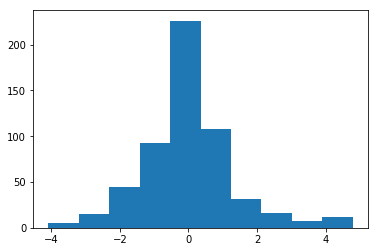

In [26]:
# Vizualize the Bayes Factor, high absolute values imply statistical significance
plt.hist(st)
plt.show()